In [33]:
import os
import time
from pathlib import Path
from getpass import getpass
from webdav3.client import Client


In [75]:

class LargeFile():
    def __init__(self, file_size, file_fp):
        self.file_fp = file_fp
        self.file_size = file_size
        os.system(f"fallocate -l {file_size} {str(file_fp)}")

    @property
    def data(self):
        return self.file_fp

class ManyFileDir():
    def __init__(self, file_size, n_files, dir_fp):
        self.file_size = file_size
        self.n_files = n_files
        self.dir_fp = Path(dir_fp)
        self.dir_fp.mkdir(exist_ok=True, parents=True)
        for i_file in range(n_files):
            file_fp = Path(dir_fp, f"{file_size}_{i_file}.bin")
            os.system(f"fallocate -l {file_size} {str(file_fp)}")

    @property
    def data(self):
        return self.dir_fp

class BenchMarkData():
    def __init__(self, local_data_dir):
        self.local_data_dir = Path(local_data_dir)
        self.local_data_dir.mkdir(exist_ok=True, parents=True)
        self.benches = {
            "500M": LargeFile("500M", Path(local_data_dir, "500M.bin")),
            "2G": LargeFile("2K", Path(local_data_dir, "2G.bin")),
            "2000x200K": ManyFileDir("200K", 20, Path(local_data_dir, "2000x200K")),
        }
        self.tmp_dir = self.local_data_dir / "temp"

    def run_filecount(self, bencher, file_size="200K"):
        # for bench_name, file_obj in self.benches.items():
        result_dict = {}
        for count in [1, 4, 8, 10, 20, 30]:
            file_obj = ManyFileDir(file_size, count, Path(self.local_data_dir, f"{count}x{file_size}"))
            start = time.perf_counter()
            bencher.upload(file_obj)
            end = time.perf_counter()
            print(count, end-start)
            result_dict[count] = end-start
        return result_dict


In [76]:
data_dir = Path.home() / Path("cache", "uu-storage")
bench = BenchMarkData(data_dir)

In [72]:
class WebDavBencher():
    def __init__(self, server, username, password, datadir="test"):
        self.client = Client({
            "webdav_hostname": server,
            "webdav_login": username,  # User name here
            "webdav_password": passwd,
            "webdav_timeout": 120,  # Time out longer for bigger files.
            "disable_check": True
        })
        self.datadir = datadir
        self.client.mkdir(datadir)

    def upload(self, file_obj):
        remote_dir = f"{self.datadir}/{file_obj.data.name}"
        self.client.mkdir(remote_dir)
        self.client.upload(remote_dir, file_obj.data)

    def download(self, file_or_dir_name, tmp_dir):
        Path(tmp_dir).mkdir(exist_ok=True, parents=True)
        self.client.download(f"{self.datadir}/{file_or_dir_name}", tmp_dir)
        

In [68]:
passwd = getpass()

In [73]:
bencher = WebDavBencher("https://surfdrive.surf.nl/files/remote.php/nonshib-webdav/",
                        "3154254@soliscom.uu.nl",
                        passwd)

In [77]:
data = bench.run_filecount(bencher)

1 2.3512058799969964
4 3.4364371140036383
8 5.260656395999831
10 6.163306111004204
20 10.152705783999409
30 14.325760086001537


In [86]:
from matplotlib import pyplot as plt
import numpy as np

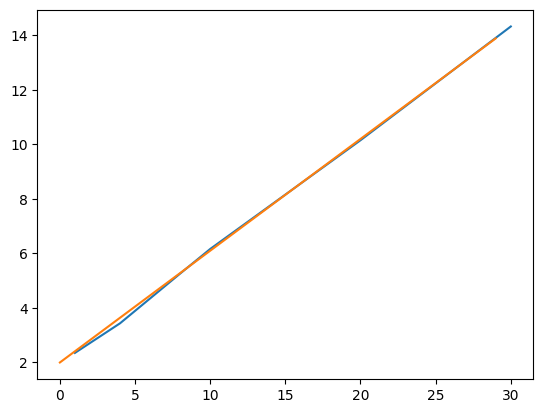

In [93]:
plt.plot(data.keys(), data.values())
plt.plot(np.arange(30), 2+0.41*np.arange(30))
plt.show()